Автор: Лейман М.А.  
Дата создания: 14.06.2025 

# Итоговая аттестация 
### __проект 7:__   _Семантическая сегментация с помощью U-Net на уличных сценах_  



## Unet++

## Импорты 

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


from data.dataset import CityscapesFlatDataset, CityscapesFlatDataset2, CityscapesFlatDataset3, prepare_cityscapes_loaders
from utils.utils import emty_cache, visualize_image_and_mask, visualize_segmentation, merge_folders, prediction_mask_onnx
from model.train import train_model
from model.predict import prediction_mask


import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
import warnings
import copy
import torch.optim as optim
import time
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.optim import lr_scheduler
from matplotlib import rcParams
import shutil
from PIL import Image
from torch.utils.data import Dataset
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import gc

warnings.filterwarnings("ignore")
np.random.seed(42)
#set_global_seed(42)
rcParams['figure.figsize'] = (14,6)

## Параметры

In [2]:
# Классы
CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])


In [3]:
# устанавливаем device если gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.7.1+cu126
версия  cuDNN:           90501
Sun Jun 29 18:17:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
| 43%   63C    P2            116W /  170W |   11656MiB /  12288MiB |     56%      Default |
|                                         

## Загрузка данных 

### Датасет

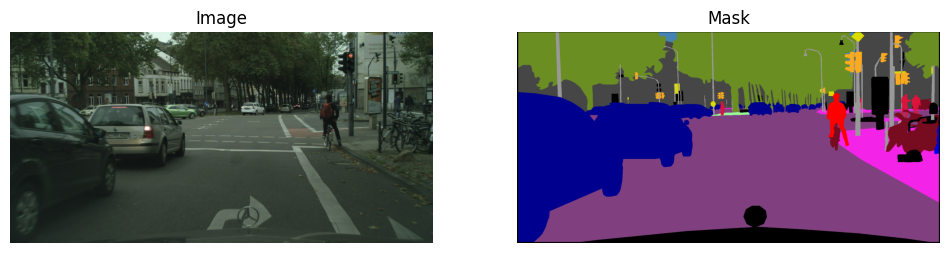

In [4]:
root_dir = './dataset/dataset'
dataset = CityscapesFlatDataset(root_dir)
image, mask = dataset[10]
visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

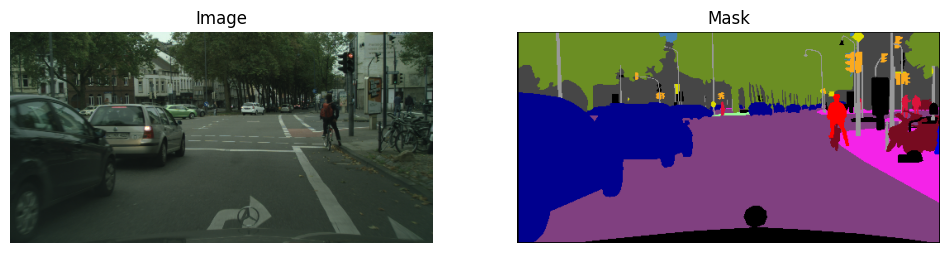

In [5]:
root_dir = './dataset/dataset'
dataset = CityscapesFlatDataset2(root_dir)
image, mask = dataset[10]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

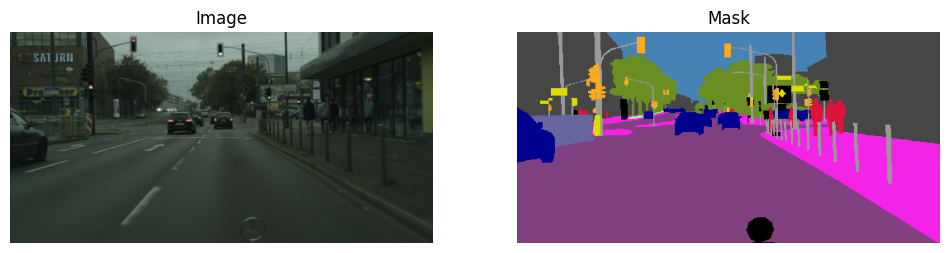

In [6]:
root_dir = './dataset/dataset_train'
dataset = CityscapesFlatDataset3(root_dir)
image, mask = dataset[11]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

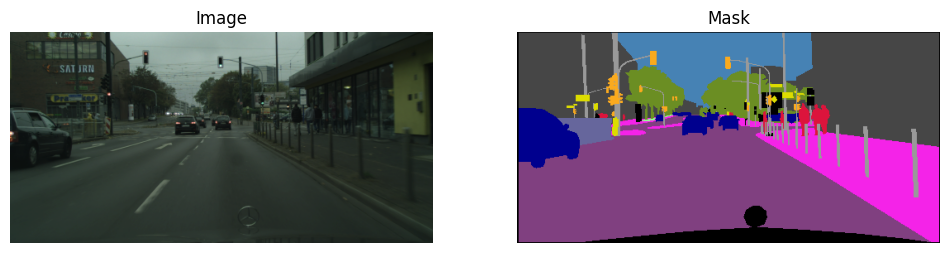

In [8]:
root_dir = './dataset/dataset_train'
dataset = CityscapesFlatDataset3(root_dir)
image, mask = dataset[9]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

In [9]:
print(np.unique(mask))

[ 0  1  2  3  4  6  7  8  9 10 11 12 14]


In [10]:
import numpy as np

unique_labels = set()

# for i in range(len(dataset)):
#     _, mask = dataset[i]  # Получаем изображение и маску
#     mask_np = mask.numpy() if hasattr(mask, 'numpy') else mask  # если тензор, преобразуем в numpy
#     unique_vals = np.unique(mask_np)
#     unique_labels.update(unique_vals.tolist())

# print("Все уникальные классы в масках:", sorted(unique_labels))


### Разделение датасета

In [11]:
batch_size = 16
size = 256, 512

train_loader, val_loader, train_dataset, val_dataset = prepare_cityscapes_loaders(
            CityscapesFlatDataset3, './dataset/dataset_train', size, batch_size=batch_size, val_ratio=0.01,
        )

# Размеры тензоров
for images, masks in train_loader:
    print(images.shape)  # [batch_size, 3, H, W]
    print(masks.shape)   # [batch_size, 1, H, W]
    masks = masks.squeeze(1)  # [batch_size, H, W]
    break



Train size: 10321, Validation size: 104
torch.Size([16, 3, 256, 512])
torch.Size([16, 256, 512])


In [12]:

_, val_loader, _, val_dataset = prepare_cityscapes_loaders(
            CityscapesFlatDataset3, './dataset/dataset_val', size, batch_size=batch_size, val_ratio=0.3,
        )


Train size: 2433, Validation size: 1042


In [12]:
# train_loader, val_loader, train_dataset, val_dataset = prepare_cityscapes_loaders(
#             CityscapesFlatDataset2, './dataset/dataset', size, batch_size=batch_size, val_ratio=0.1,
#         )


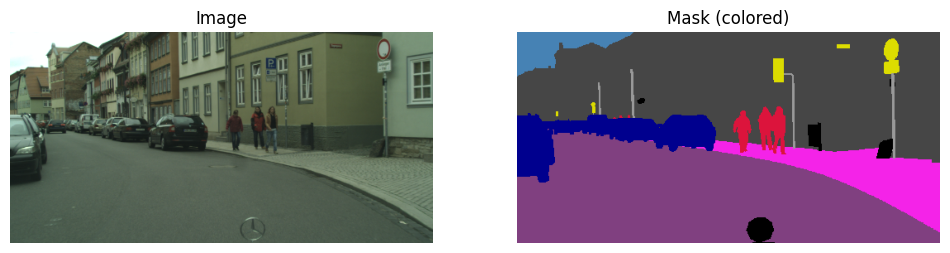

In [17]:
import numpy as np
import matplotlib.pyplot as plt

CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])

def mask_to_rgb(mask):
    # mask: H x W (numpy array, dtype=int or torch.Tensor)
    if hasattr(mask, 'cpu'):
        mask = mask.cpu().numpy()
    rgb = CITYSCAPES_PALETTE[mask]
    return rgb

# Пример вывода пары изображение+цветная маска из батча
def show_image_and_colored_mask(image, mask):
    # image: torch.Tensor (C, H, W)
    # mask: torch.Tensor (H, W)
    image = image.cpu().numpy()
    mask = mask.cpu().numpy()
    # Денормализация
    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    image = np.transpose(image, (1, 2, 0))
    mask_rgb = mask_to_rgb(mask)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask_rgb)
    axes[1].set_title('Mask (colored)')
    axes[1].axis('off')
    plt.show()

# Использование:
batch = next(iter(train_loader))
images, masks = batch
show_image_and_colored_mask(images[0], masks[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7475592..2.2299752].


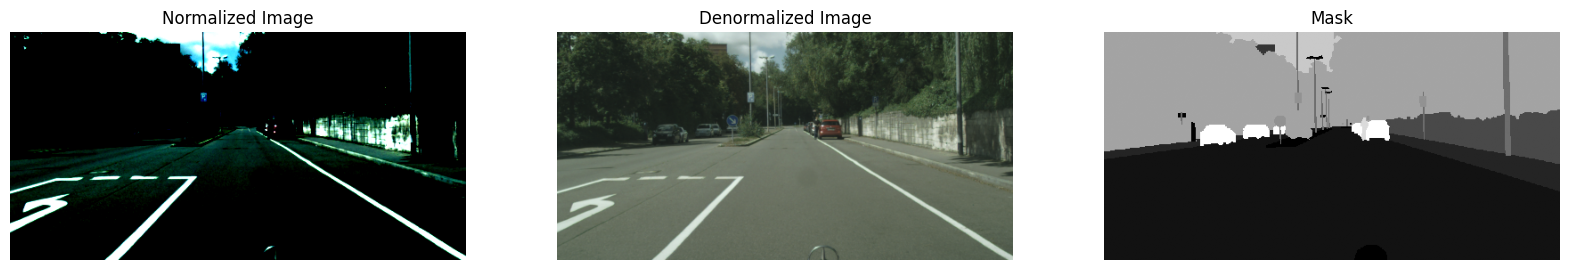

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.105687..2.64].


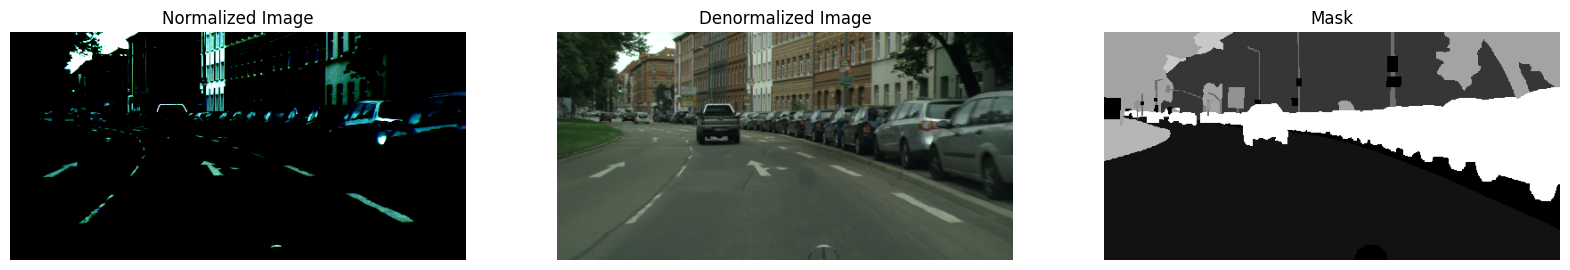

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

def denormalize(image):
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    return image

def show_images_and_masks(images, masks):
    for i in range(min(2, len(images))):
        image = images[i].cpu().numpy() if hasattr(images[i], 'cpu') else images[i]
        mask = masks[i].cpu().numpy() if hasattr(masks[i], 'cpu') else masks[i]
        denorm_image = denormalize(image)
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
        axes[0].imshow(np.transpose(image, (1, 2, 0)))
        axes[0].set_title('Normalized Image')
        axes[0].axis('off')

        axes[1].imshow(np.transpose(denorm_image, (1, 2, 0)))
        axes[1].set_title('Denormalized Image')
        axes[1].axis('off')

        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Mask')
        axes[2].axis('off')

        plt.show()


batch = next(iter(train_loader))
images, masks = batch
show_images_and_masks(images, masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9660194..2.64].


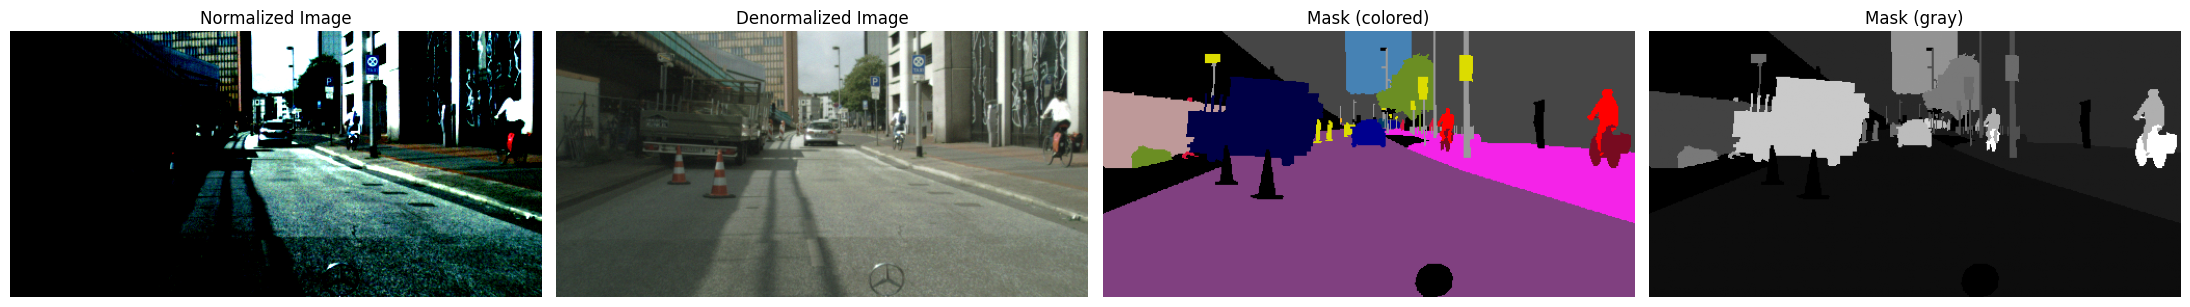

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


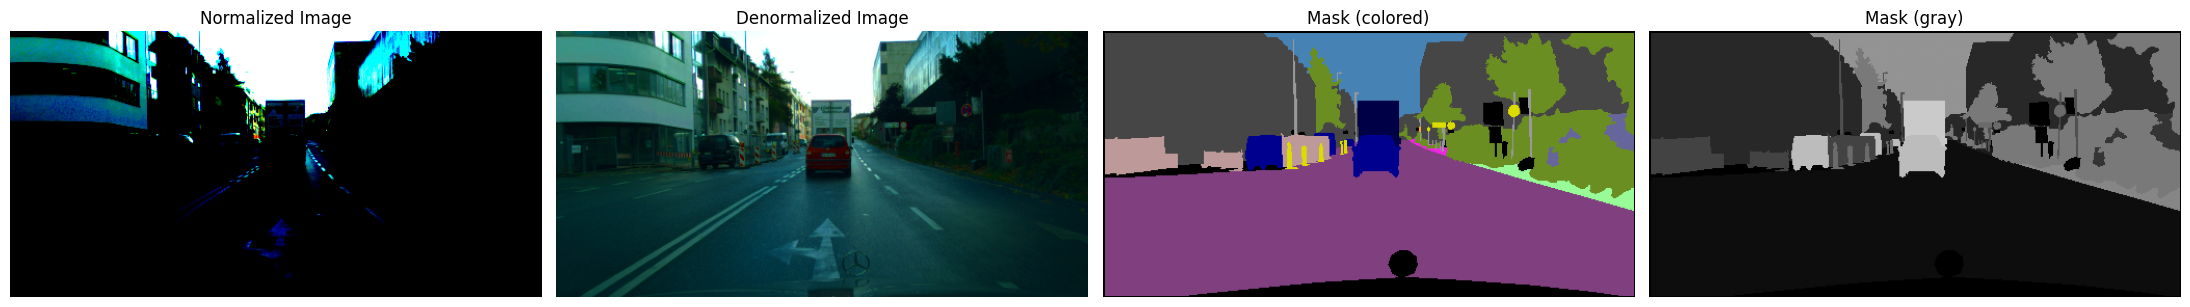

In [13]:
import numpy as np
import matplotlib.pyplot as plt

CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])

mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

def mask_to_rgb(mask):
    """Преобразует маску в цветное изображение по палитре Cityscapes."""
    if hasattr(mask, 'cpu'):
        mask = mask.cpu().numpy()
    return CITYSCAPES_PALETTE[mask]

def denormalize(image):
    """Денормализует изображение."""
    return np.clip((image * std) + mean, 0, 1)

def show_images_and_masks(images, masks, num=2):
    """
    Выводит num пар: нормализованное изображение, денормализованное изображение,
    цветная маска и маска в оттенках серого.
    """
    for i in range(min(num, len(images))):
        image = images[i].cpu().numpy() if hasattr(images[i], 'cpu') else images[i]
        mask = masks[i].cpu().numpy() if hasattr(masks[i], 'cpu') else masks[i]
        denorm_image = denormalize(image)
        mask_rgb = mask_to_rgb(mask)

        fig, axes = plt.subplots(1, 4, figsize=(22, 7))
        axes[0].imshow(np.transpose(image, (1, 2, 0)))
        axes[0].set_title('Normalized Image')
        axes[0].axis('off')

        axes[1].imshow(np.transpose(denorm_image, (1, 2, 0)))
        axes[1].set_title('Denormalized Image')
        axes[1].axis('off')

        axes[2].imshow(mask_rgb)
        axes[2].set_title('Mask (colored)')
        axes[2].axis('off')

        axes[3].imshow(mask, cmap='gray', vmin=0, vmax=19)
        axes[3].set_title('Mask (gray)')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

# Использование:
batch = next(iter(train_loader))
images, masks = batch
show_images_and_masks(images, masks, num=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..1.9383754].


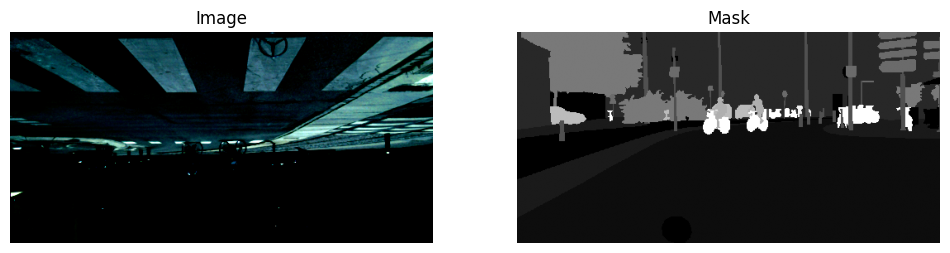

In [14]:
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image.permute(1, 2, 0))  # Если image — torch.Tensor с каналами первым
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

# Получение первого батча из train_loader
batch = next(iter(train_loader))
images, masks = batch

# Отображение первого изображения и маски
show_image_and_mask(images[0], masks[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295316..1.9033613].


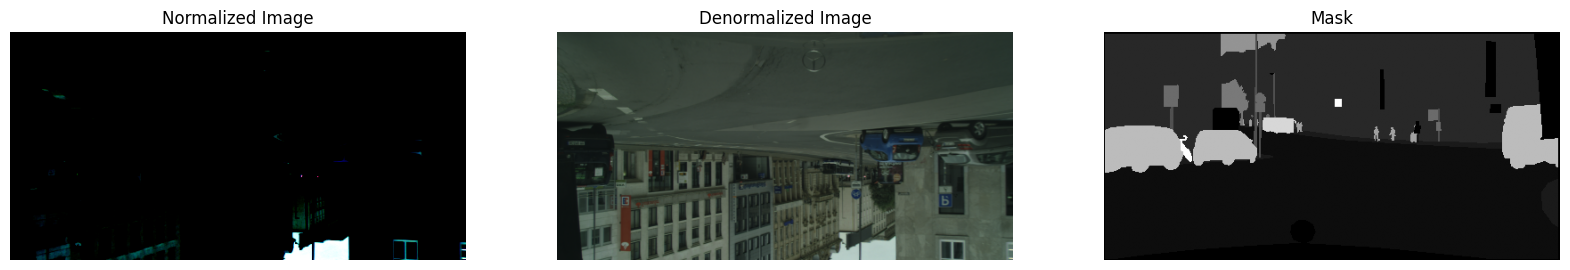

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Значения mean и std такие же, как в вашем датасете
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

def denormalize(image):
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    return image

def show_image_denorm_and_mask(image, mask):
    # image и mask — torch.Tensor или numpy.ndarray
    # Преобразуем к numpy, если это torch.Tensor
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()
    denorm_image = denormalize(image)
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    axes[0].imshow(image.transpose(1, 2, 0))
    axes[0].set_title('Normalized Image')
    axes[0].axis('off')

    axes[1].imshow(denorm_image.transpose(1, 2, 0))
    axes[1].set_title('Denormalized Image')
    axes[1].axis('off')

    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.show()

# Использование с вашим датасетом:
image, mask = train_dataset[0]  # или другой индекс
show_image_denorm_and_mask(image, mask)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].


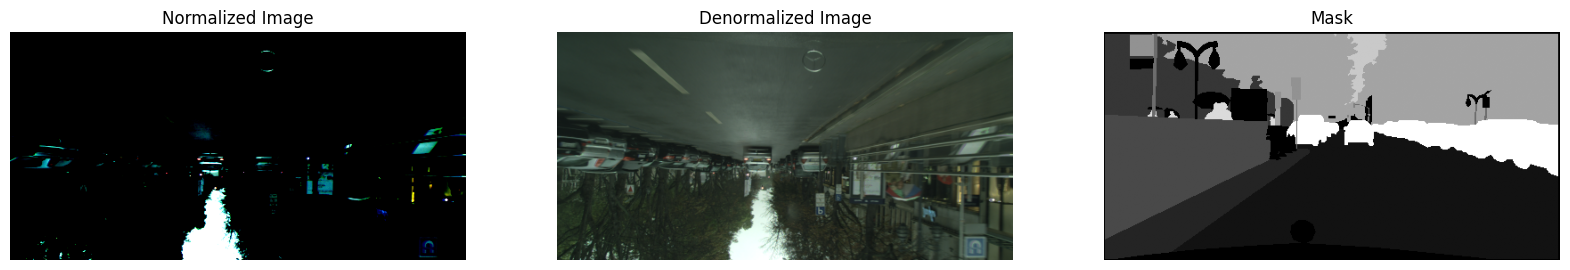

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582841..2.64].


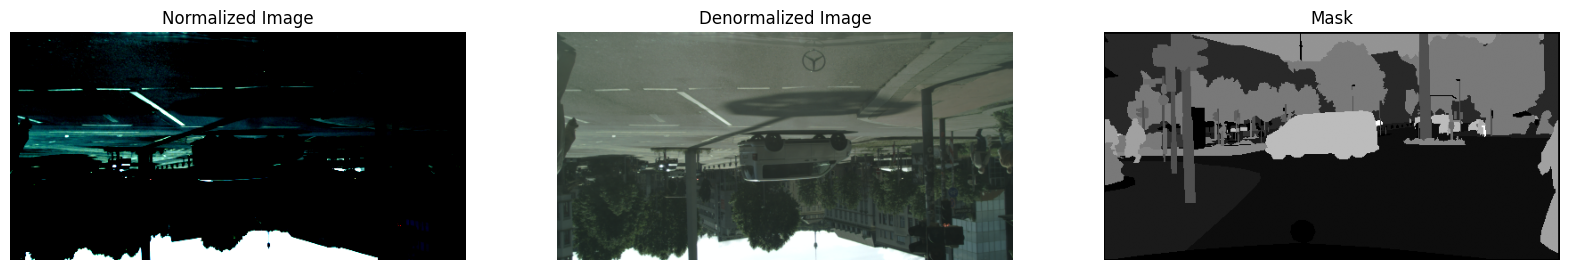

In [16]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

def denormalize(image):
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    return image

def show_images_and_masks(images, masks):
    for i in range(min(2, len(images))):
        image = images[i].cpu().numpy() if hasattr(images[i], 'cpu') else images[i]
        mask = masks[i].cpu().numpy() if hasattr(masks[i], 'cpu') else masks[i]
        denorm_image = denormalize(image)
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
        axes[0].imshow(np.transpose(image, (1, 2, 0)))
        axes[0].set_title('Normalized Image')
        axes[0].axis('off')

        axes[1].imshow(np.transpose(denorm_image, (1, 2, 0)))
        axes[1].set_title('Denormalized Image')
        axes[1].axis('off')

        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Mask')
        axes[2].axis('off')

        plt.show()

# Использование с вашим DataLoader:
batch = next(iter(train_loader))
images, masks = batch
show_images_and_masks(images, masks)


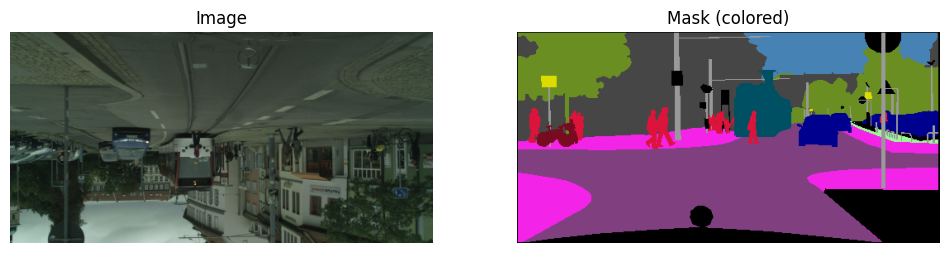

In [17]:
import numpy as np
import matplotlib.pyplot as plt

CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])

def mask_to_rgb(mask):
    # mask: H x W (numpy array, dtype=int or torch.Tensor)
    if hasattr(mask, 'cpu'):
        mask = mask.cpu().numpy()
    rgb = CITYSCAPES_PALETTE[mask]
    return rgb

# Пример вывода пары изображение+цветная маска из батча
def show_image_and_colored_mask(image, mask):
    # image: torch.Tensor (C, H, W)
    # mask: torch.Tensor (H, W)
    image = image.cpu().numpy()
    mask = mask.cpu().numpy()
    # Денормализация
    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    image = np.transpose(image, (1, 2, 0))
    mask_rgb = mask_to_rgb(mask)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask_rgb)
    axes[1].set_title('Mask (colored)')
    axes[1].axis('off')
    plt.show()

# Использование:
batch = next(iter(train_loader))
images, masks = batch
show_image_and_colored_mask(images[0], masks[0])


In [ ]:
# #################  Визуализация 
def decode_segmap(mask, colormap):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(len(colormap)):
        color_mask[mask == cls_id] = colormap[cls_id]
    return color_mask



# Функция визуализации
def visualize_segmentation(image_pil, pred_mask, colormap, alpha=0.5):
    """
    image_pil: PIL.Image — исходное изображение
    pred_mask: torch.Tensor или numpy.ndarray (H, W) с классами
    colormap: dict с цветами классов
    alpha: прозрачность наложения маски
    """
    # Преобразуем PIL Image в numpy (H, W, 3)
    image_np = np.array(image_pil.convert("RGB"))

    # Если pred_mask — тензор, преобразуем в numpy
    if hasattr(pred_mask, 'cpu'):
        pred_mask = pred_mask.cpu().numpy()

    # Убираем лишние размерности, если есть
    if pred_mask.ndim == 3:
        pred_mask = pred_mask.squeeze(0)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, got shape {pred_mask.shape}")

    # Получаем цветную маску
    color_mask = decode_segmap(pred_mask, colormap)
    image_resized = image_pil.resize((512, 256), resample=Image.BILINEAR)
    image_np = np.array(image_resized)
    # Накладываем маску на изображение с прозрачностью
    overlay = (image_np * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    # Визуализация
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.title("Исходное изображение")
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Сегментированные маски")
    plt.imshow(color_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Наложение")
    plt.imshow(overlay)
    plt.axis('off')

    plt.show()


In [ ]:

# Препроцесс для ONNX 
def preprocess_image_onnx(path_img, input_size=(512, 256)):
    img = Image.open(path_img).convert('RGB')
    img = img.resize(input_size)  
    img_np = np.array(img).astype(np.float32) / 255.0

    # Нормализация ImageNet
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_np = (img_np - mean) / std

    # HWC -> CHW
    img_np = img_np.transpose(2, 0, 1)

    # Добавляем batch dimension
    img_np = np.expand_dims(img_np, axis=0)

    return img, img_np

# Предсказание ONNX
def prediction_mask_onnx(path_img, onnx_session):
    img, img_np = preprocess_image_onnx(path_img)

    
    input_name = onnx_session.get_inputs()[0].name
    outputs = onnx_session.run(None, {input_name: img_np})

    # outputs[0] — выход модели, shape (1, num_classes, H, W)
    pred_mask = np.argmax(outputs[0], axis=1)[0]  # (H, W)

    return img, pred_mask




In [ ]:
import numpy as np
import cv2
from PIL import Image

def adjust_saturation(img_np, factor):
    # img_np: HWC, float32, диапазон [0, 1]
    img_uint8 = (img_np * 255).astype(np.uint8)
    img_hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    img_hsv[..., 1] = np.clip(img_hsv[..., 1] * factor, 0, 255)
    img_hsv = img_hsv.astype(np.uint8)
    img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return img_rgb.astype(np.float32) / 255.0

def adjust_contrast(img_np, factor):
    # img_np: HWC, float32, диапазон [0, 1]
    mean = img_np.mean(axis=(0, 1), keepdims=True)
    img_adj = np.clip((img_np - mean) * factor + mean, 0, 1)
    return img_adj

def preprocess_image_onnx(path_img, input_size=(512, 256), sat_factor=1.0, contrast_factor=1.0):
    img = Image.open(path_img).convert('RGB')
    img = img.resize(input_size)
    img_np = np.array(img).astype(np.float32) / 255.0  # HWC, float32, [0, 1]

    # Аугментация: изменение насыщенности
    if sat_factor != 1.0:
        img_np = adjust_saturation(img_np, sat_factor)

    # Аугментация: изменение контраста
    if contrast_factor != 1.0:
        img_np = adjust_contrast(img_np, contrast_factor)

    # Нормализация ImageNet
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_np = (img_np - mean) / std

    # HWC -> CHW
    img_np = img_np.transpose(2, 0, 1)

    # Добавляем batch dimension
    img_np = np.expand_dims(img_np, axis=0)

    return img, img_np



# Предсказание ONNX
def prediction_mask_onnx(path_img, onnx_session):
    img, img_np = preprocess_image_onnx(
            path_img,
            input_size=(512, 256),
            sat_factor=0.5,        # увеличить насыщенность на 20%
            contrast_factor=2   # уменьшить контраст на 10%
        )


    
    input_name = onnx_session.get_inputs()[0].name
    outputs = onnx_session.run(None, {input_name: img_np})

    # outputs[0] — выход модели, shape (1, num_classes, H, W)
    pred_mask = np.argmax(outputs[0], axis=1)[0]  # (H, W)

    return img, pred_mask






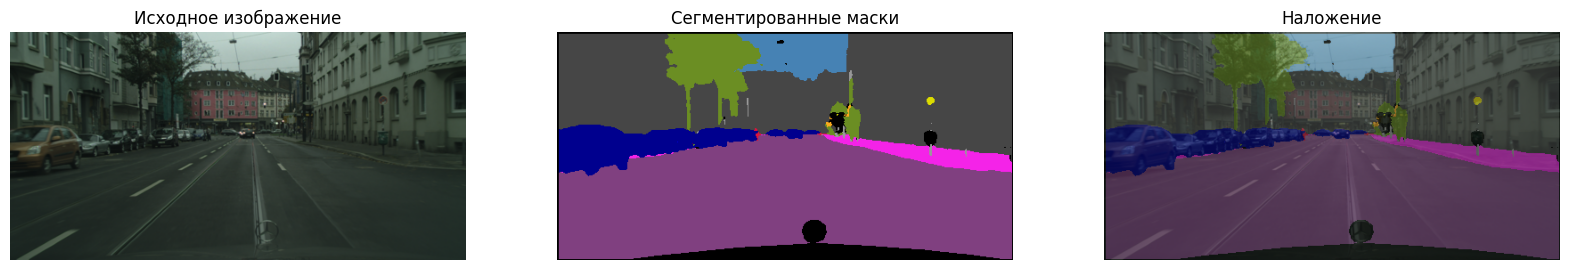

In [21]:
import onnxruntime as ort
path_img = '/home/maksim/develops/python/MAKSIM/Attestation/dataset/dataset_val/images/999.png'

session = ort.InferenceSession("models/unetpp_model.onnx")
img, mask = prediction_mask_onnx(path_img, session)


visualize_segmentation(img, mask, CITYSCAPES_PALETTE)

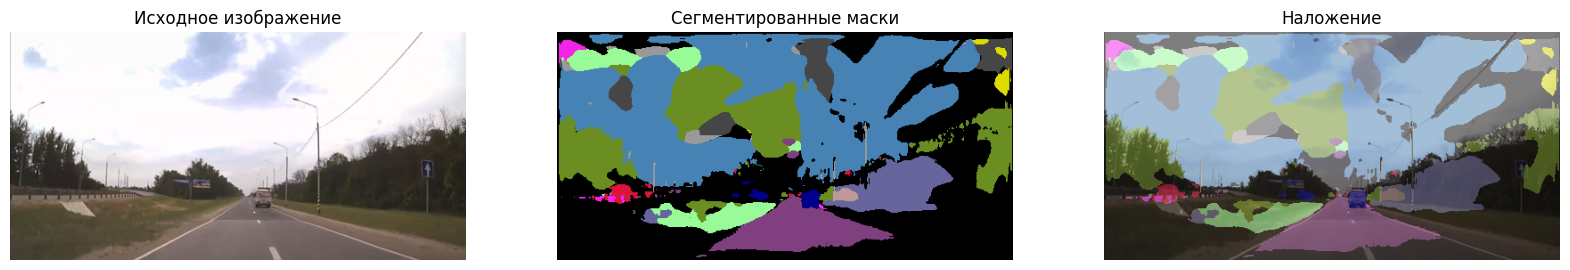

In [20]:
import onnxruntime as ort
path_img = '/home/maksim/develops/python/MAKSIM/Attestation/videos/22.png'

session = ort.InferenceSession("models/unetpp_model.onnx")
img, mask = prediction_mask_onnx(path_img, session)


visualize_segmentation(img, mask, CITYSCAPES_PALETTE)